In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [ ]:
# load in image data
# MNIST IMAGE -> Tensors

In [6]:
transform = transforms.ToTensor()

In [7]:
train_data = datasets.MNIST(root="./", train=True, download=True, transform=transform)

14.0%

100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


78.0%%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


180.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [10]:
test_data = datasets.MNIST(root="./", train=False, download=True, transform=transform)

In [11]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [15]:
image, label = train_data[0]

In [17]:
image.shape

torch.Size([1, 28, 28])

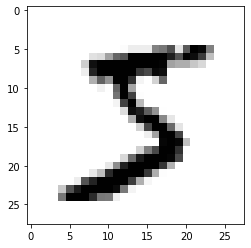

In [18]:
plt.imshow(image.reshape((28,28)), cmap='gist_yarg')

In [20]:
torch.manual_seed(101)

In [22]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True) 
#100 images fed into network at a time

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [23]:
from torchvision.utils import make_grid

In [24]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # FORMATTING

In [30]:
# Explore first batch

In [25]:
# FIRST BATCH
for images, labels in train_loader:
    break

In [28]:
images.shape # 100 images of 1 colour channel in a 28x28 image

torch.Size([100, 1, 28, 28])

In [29]:
labels.shape

torch.Size([100])

In [31]:
labels

tensor([0, 5, 7, 8, 6, 7, 9, 7, 1, 3, 8, 4, 4, 2, 2, 1, 3, 7, 1, 6, 3, 1, 0, 4,
        6, 4, 6, 9, 1, 1, 4, 0, 1, 4, 1, 8, 9, 3, 2, 1, 0, 9, 3, 1, 1, 3, 0, 2,
        1, 6, 7, 5, 5, 1, 3, 7, 4, 9, 2, 9, 9, 7, 0, 9, 8, 5, 2, 1, 8, 8, 6, 1,
        7, 3, 9, 4, 8, 5, 3, 0, 4, 4, 7, 9, 3, 4, 2, 8, 8, 5, 3, 5, 6, 8, 1, 2,
        7, 0, 6, 7])

In [32]:
# Print first 12 images

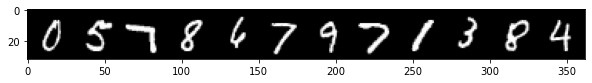

In [33]:
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

# Multi-layer perceptron model

In [38]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, in_sz=784,out_sz=10,layers=[120,84]):
        
        super().__init__()
        
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self,X):
        # fc = fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1) # softmax for multi-class classification

In [39]:
torch.manual_seed(101)

In [40]:
model = MultilayerPerceptron()

In [41]:
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [43]:
# show total number of parameters in the model
for param in model.parameters():
    print(param.numel())
    
# 1. all connections from 784 to 120 (weights)
# 2. 120 bias 
# 3. all connections from 120 neurons to 84 neurons
# 4. 84 bias 
# 5. all connections from 84 neurons to 10 neurons
# 6. 10 bias

94080
120
10080
84
840
10


In [44]:
# total parameters: 105214 total parameters

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
images.shape # flatten into 100 images of 784 pixels ---> [100, 784]

torch.Size([100, 1, 28, 28])

In [50]:
images.view(100, -1).shape # view method with second parameter -1 causes flatten

torch.Size([100, 784])

# Model training

In [55]:
import time 
start_time = time.time()

# set up number of iterations of ANN
epochs = 10

# Metrics to track
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# train model
for i in range(epochs):
    trn_corr = 0 # correctly predicted during training
    tst_corr = 0 # correctly predicted during testing
    
    # b for "batch"
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 
        
        # 10 neurons
        # [0.1,0.0,....0.8]
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item()*100/(100*b)
            print(f'Epoch {i} batch{b} loss:{loss.item()} accuracy: {acc}')
        
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # no_grad stops updating the weights and biases
    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted==y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f'Duration: {total_time/60} minutes')

Epoch 0 batch200 loss:0.043936558067798615 accuracy: 97.55
Epoch 0 batch400 loss:0.08064968883991241 accuracy: 97.5175
Epoch 0 batch600 loss:0.04593101516366005 accuracy: 97.54166666666667
Epoch 1 batch200 loss:0.15204916894435883 accuracy: 97.905
Epoch 1 batch400 loss:0.11123093962669373 accuracy: 97.9825
Epoch 1 batch600 loss:0.13759036362171173 accuracy: 97.995
Epoch 2 batch200 loss:0.05522346496582031 accuracy: 98.37
Epoch 2 batch400 loss:0.047315653413534164 accuracy: 98.3925
Epoch 2 batch600 loss:0.0643383339047432 accuracy: 98.39166666666667
Epoch 3 batch200 loss:0.002775677479803562 accuracy: 98.895
Epoch 3 batch400 loss:0.05013709515333176 accuracy: 98.8
Epoch 3 batch600 loss:0.0702788233757019 accuracy: 98.68166666666667
Epoch 4 batch200 loss:0.04630101099610329 accuracy: 99.01
Epoch 4 batch400 loss:0.050923045724630356 accuracy: 98.9825
Epoch 4 batch600 loss:0.05717475339770317 accuracy: 98.93833333333333
Epoch 5 batch200 loss:0.016825806349515915 accuracy: 99.24
Epoch 5 bat

# Evaluation

In [62]:
train_losses = list(map(lambda x: x.item(),train_losses))

In [63]:
test_losses = list(map(lambda x: x.item(),test_losses))

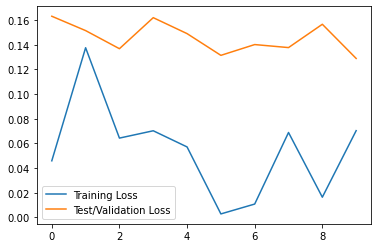

In [64]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()

In [ ]:
train_correct[]

In [66]:
train_correct = list(map(lambda x: x.item(),train_correct))

In [67]:
test_correct = list(map(lambda x: x.item(),test_correct))

In [69]:
train_acc = [t/600 for t in train_correct] # divide by batch size
test_acc = [t/100 for t in test_correct] # divide by batch size

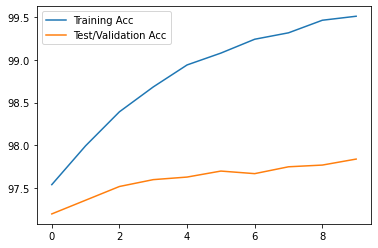

In [70]:
plt.plot(train_acc, label='Training Acc')
plt.plot(test_acc, label='Test/Validation Acc')
plt.legend()